# Assignment 1: _Computing the Area of the Mandelbrot Set_

This assignment was authored by (format: Name [Student ID]):

Karolina Chlopicka [15716546] <br>
Shania Sinha [14379031] <br>
Salomé Poulain [13955993]

## 1: Creating the Mandelbrot Set

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

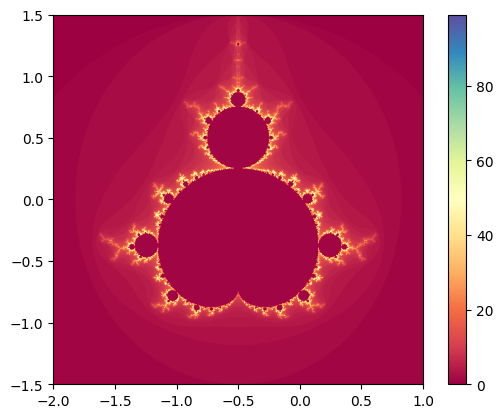

In [ ]:
# Creating a mandelbrot set
def mandelbrot(c, max_iter):
    z = c
    for n in range(max_iter):
        if abs(z) > 2:
            return False
        z = z*z + c
    return True

# Set the size of the image
img_size = 1000

# Create a blank image
img = np.zeros((img_size, img_size))

# Set the range of the image
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5

# Create the image
for i in range(img_size):
    for j in range(img_size):
        x = x_min + (x_max - x_min) * i / img_size
        y = y_min + (y_max - y_min) * j / img_size
        c = x + 1j * y
        color = mandelbrot(c, 100)
        img[i, j] = color

# Display the image
plt.imshow(img, cmap='Spectral', extent=[x_min, x_max, y_min, y_max])
plt.colorbar() 
plt.show()


## 2: Estimation of Area Mandelbrot Set using Monte-Carlo